## Trust and Mortgage Loan Companies (Excluding bank trust and mortgage subsidiaries)
License = [Open Canada Lisence](http://open.canada.ca/en/open-government-licence-canada)  
Database retrieved from Open Canada portal. [Link to the database](http://open.canada.ca/data/en/dataset/fecb7f75-8bf5-4fcb-859f-53b14ae81c59)

### Purpose of the Notebook
The purpose of creating this notebook is to demonstrate my ability to find, manipulate, and present data in a clear fashion. I want to show my ability to find useful quantitative and qualitative insights under a time constraint, show my initiative to take on new projects, and my willingness to learn new topics and skills to land a position at PwC

### Data 
The database is a balance sheet of all trust and mortgage loan companies in Canada, in quarters from 1984 to 2016.  The information was found from the Government of Canada's open data portal.  It was selected as PwC is one of the 'Big 4' accounting firms, and I'd love to enhance my knowledge of how to work with balance sheet data.

### Importing and cleaning the data
Steps:
1. Importing required modules and adding visualization techniques to the notebook
2. Retreiving the CSV file from my GitHub page
3. Cleaning the data using the following steps
 1. Delete unnecessary columns
 2. Set index to datetime functions
 3. Split the ASSET column into sub-columns of balance sheet entries
 4. Concatenate the columns to create a clean database
4.  To avoid errors in database modification, database creation is a function, create_database

In [118]:
## importing necessary models and visualizations 
import pandas as pd 
from datetime import datetime
%matplotlib inline
from IPython.display import display
pd.set_option('max_columns', 48)
current_loc = %pwd

In [119]:
## create_database() reads a locally-stored excel file,
##  cleans the data to be used in a pandas DataFrame,
##  and returns a pandas DataFrame
## NaN -> DataFrame
def create_database():
    finance_df = pd.read_csv(current_loc + '/Mortgage & Loan Company Finances/Mortgage and loan company finances.csv')
    del finance_df['GEO'], finance_df['Coordinate'], finance_df['Vector']
   
    # creating the index as TimeStamps
    finance_df_row = finance_df['Ref_Date'].map(lambda x: datetime.strptime(x, '%Y/%m'))
    finance_df['Ref_Date'] = finance_df_row
    finance_df = finance_df.set_index('Ref_Date')
    
    # creating columns names and column entries
    columns = finance_df['ASSET'].unique().tolist()
    value_lst = []
    for column in columns:
        new_col = finance_df[finance_df['ASSET'] == column]
        value_lst.append(new_col['Value'])
    # finalizing the database format and column names
    strped_cols = []
    for column in columns:
        strped_name = column.strip(' (x 1,000,000)') 
        strped_cols.append(strped_name)    
    
    finance_df = pd.DataFrame(value_lst).T
    finance_df.columns = strped_cols

    return finance_df

finance_df = create_database()


### Initial thoughts after exploring the database
* **Lots of missing data after 2007:** It appears as though the database became far more general where information for asset and liability subgroups is not entered
* ** 1999 and 2008:** Both are known to be major crashes, with 1999 (to my current knowledge) being as a result of the internet bubble and 2008 for the sub-prime mortgage crisis.  It appears something serious occured in terms of regulations between Dec 1 1999 and Mar 1 2000, as the total assets of the industry decreased by ~ 80% 
* **Personal Loans** The most severe drop was visible in the personal loans area, where loans dropped from \$17.2 billion to \$685 million, a _96%_ increase

### Next step - Personal loans and residential mortgage loans
I have chosen to focus on personal loans and residential mortgage loans and pull some quantitative and qualitative insights from the data.  I have chosen this as I believe it would have the most personal benefit to me to understand the overall trends of both personal loans and residential mortgages.  

First, we will inspect time-series line graph of personal loans. It is extremely clear that around the end of 1999, there was a serious decrease in personal loans, and in 2009, there was a steady increase in personal loans for about 4 years.  These increases and decreases appear to have something to do with regulation due to market crashes.  Let's look into some external research: 

**_1999 personal loans value_**  
The total value of personal loans owned by mortgage and loan companies dropped from **\$17.2 billion** to **\$685 million**.  While there was a stock market crash, there was no major increase in interest rates.  The loans were not all paid back suddenly, as the overall assets significantly decreased.  As personal loans are assets, they did not have to disappear.  The personal loans may simply be written off the books. 

The data is an overview of all mortgage and trust companies, thus it is unlikely that essentially all companies decided to take majority of personal loans off the books.  My best guess is a Canadian legislation which required mortgage and loan companies to hold a set amount of assets, including personal loans.  

To find more information, the first stop will be the Government of Canada's legal section.  There is a webpage which lists all the current laws and regulations  affecting trust and loan companies.   

[Link to the page](http://www.fcac-acfc.gc.ca/eng/forIndustry/regulatedEntities/Pages/Overview-Apercced-3.aspx)

Upon searching and looking through the Trust and Loan Companies Act, Section 483.3 reveals the answer to the sudden drop of value (pictured below)

![Picture of the law](https://raw.githubusercontent.com/Hudsonash/Images-for-GitHub/master/Section%20483.3%20-%20Trust%20and%20Mortgage%20laws.png)

The law explains the sudden drop in the assets held by a company.  There are several other mentions of the 5% rule of total assets.

**_2009 increase_** 
A common theme in the Trust and Loan Companies Act is the superindendent's exception.  The superintendent has the permission to allow companies to increase their assets held within the company.  I assume the increase in assets was due to the mortgage crisis, allowing companies to have more liquidity due to the sub-prime mortgages.  




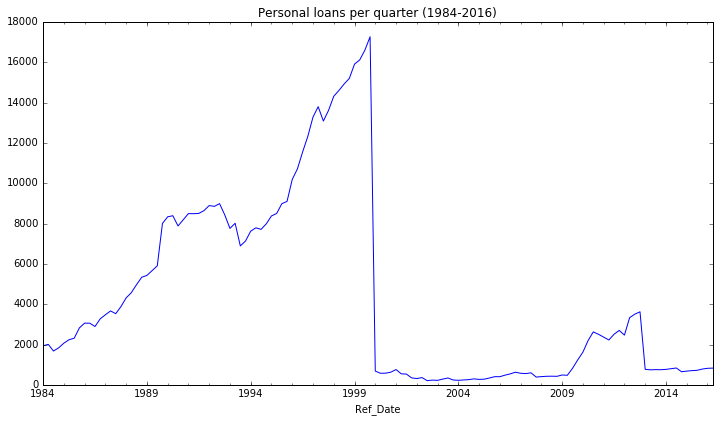

In [120]:
## graph of the personal loans per quarter
finance_df['Personal loans'].plot.line(figsize = (12, 6.5), title = 'Personal loans per quarter (1984-2016)')

### Finding an accurate forecast
After 2009, the personal loans time-series does not appear to have any seasonality or trend.  The data appears to be rather chaotic due to the heavy regulation on the industry.  Here are some issues with forecasting the demand: 
* **High variability due to regulations**: The enourmous drop in 1999 and increase in 2008 make it difficult to create a forecast using all the data.  
* **Many factors at play**: The total assets of mortgage and trust companies will need to adjust to many macroeconomic issues, such as government changes, stock market crashes, currency, interest rates, and many more.  

### 4-quarter moving average
The forecast will begin at Q1, 2000.  Below is a table of the quarter, the actual value, and the forecasted value, including a plot of the forecast and the mortgage loans.

The 4-quarter moving average uses the previous 4 quarters' actual values and estimates the next value based off of this. Mathematically, 

$$F(t+1) = \frac{\sum_{t-4}^t Actual(t)}{4} $$

The creation of a 4-quarter moving average is seen below, and the graph is also below to 

In [121]:
# new dataframe using only information from personal loans 
forecast_df = finance_df.loc['2000':][['Personal loans']]

# a loop that creates all the required forecasts and appends it to the 
#  forecast dataframe to be visualized
forecasts = [0,0,0]
forecast_beg_count = 0
while forecast_beg_count + 4 <= len(forecast_df):
    values = forecast_df.iloc[forecast_beg_count:forecast_beg_count+4]['Personal loans']
    forecast = values.sum() / 4 
    forecasts.append(forecast)
    forecast_beg_count += 1
forecast_df['Forecast'] = forecasts

# displaying the first 10 entries of the table 
forecast_df.iloc[-10:]




,Personal loans,Forecast
Ref_Date,,
2014-03-01,770,757.00
2014-06-01,802,770.50
2014-09-01,839,791.00
2014-12-01,652,765.75
2015-03-01,683,744.00
2015-06-01,708,720.50
2015-09-01,724,691.75
2015-12-01,786,725.25
2016-03-01,823,760.25


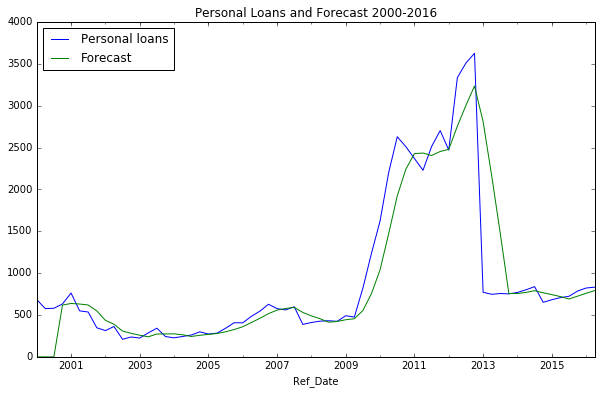

In [122]:
## visualizing the forecast and the personal loans total assets 
forecast_df.loc['2000':].plot.line(figsize = (10,6), title = 'Personal Loans and Forecast 2000-2016')

### What can this tell us?
The forecast above attempts to predict the total value of personal loans held by mortgage and trust companies in Canada.  The forecast dictates that the personal loans will reach a total value of $791 million dollars in the third quarter of 2016.  

### What does this mean?
With the qualitative research, it appeared a company can only hold 5% of its total assets within the company.  Assuming that each company holds to the maximum of 5% for personal loans, the total value of all the companies is forecasted to be:

$$ 791 * 20 = 15820 $$  
This shows that there is predicted to be roughly $15.82 billion dollars in personal loans in Canada.  

What can actually be discovered from these results?  The forecasting of the total value of personal loans may seem a bit useless on its own.  However, combined with other macroeconomic factors, it could be used as a possible data point to discover how different types of debt, specifically personal debt, affect the interest rates and other future predictions of Canada 

### Using Tableau to visualize 
Using Tableau Public, I must export the forecasted DataFrame to an excel spreadsheet to be able to read the data.   
[Link to Tableau Public graph](https://public.tableau.com/profile/publish/Forecastingdemandofpersonalloanassets/Sheet1#!/publish-confirm)

In [124]:
## exporting the forecast DataFrame to an excel sheet
writer = pd.ExcelWriter(current_loc +'/Mortgage & Loan Company Finances/Tableau personal loans.xlsx',
                        engine = 'xlsxwriter')
forecast_df.to_excel(writer)
writer.close()
